## Create a Model to find the best spot for my skate session

My goal for this project is to build the best machine learning model to help me find the best skatepark for my session, according of the week day, the weather, temperature and the traffic time.
Montréal has 14 skateparks, sometimes it's hard for me to choose the best spot.
The input will be:
 -  the weather (of course, I don't want to skate outside if it snows...)
 -  the temperature 
 -  the traffic time (Sometimes the traffic at Montréal is a nightmare)
 - I also gave a general grade for the skatepark..

## Connexion to the S3 bucket and get the data:

In [10]:
import os, boto3, random
import pandas as pd
from botocore.exceptions import ClientError
from io import StringIO
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

## Get Data from S3:

For the model, as it's a simple regression, we can just give as a input 1 spot index, and not the 14 skatespots.
The time to do all the inference will not be a problem, it's not a critical system.
It will be easier to me to add skateparks, Montreal build new one, in the future.

In [2]:
s3 = boto3.client(
    "s3",
    endpoint_url=os.getenv("S3_ENDPOINT"),
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="us-east-1"
)

In [3]:
BUCKET_NAME = "skatedata"          # ton bucket
FILE_KEY = "skatepark_dataset_test.csv"  # ton fichier CSV

obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
df = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

print(df.head())

     spot_name  index spot  weather  temperature  traffic_time  weekday  \
0     Ahuntsic           0        3         15.8           5.0        1   
1     VanHorne           1        3         15.8           5.0        1   
2       Verdun           2        3         15.8           5.0        1   
3      Lasalle           3        3         15.8           5.0        1   
4  Préfontaine           4        3         15.8           5.0        1   

   park_score  satisfaction  
0         8.0           9.0  
1         4.0           2.0  
2         2.0           1.0  
3         8.5           9.0  
4         8.5           8.0  


## Generator:


In [4]:
random.seed(1)

INPUTS_COLS = ["index spot", "weather", "temperature", "traffic_time", "weekday", "park_score"]
OUTPUT_COL =  "satisfaction"
TRAINING_PERCENTAGE = 90



dataset = [
                [row[INPUTS_COLS].tolist(), row[OUTPUT_COL]]
                for _, row in df.iterrows()
            ]
random.shuffle(dataset)

split_idx = int(TRAINING_PERCENTAGE / 100 * len(dataset))
train_dataset = dataset[:split_idx]
val_dataset = dataset[split_idx:]


import numpy as np

def generator(part_dataset, batch_size=4):
    X_batch, y_batch = [], []

    while True:
        for X, y in part_dataset:
            X_batch.append(X)
            y_batch.append(y)

            if len(X_batch) == batch_size:
                yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
                X_batch, y_batch = [], []

        if X_batch:
            yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
            X_batch, y_batch = [], []


## Model Architecture:

First Model tested will be 5 Dense Layers.

In [5]:
INPUT_DIM = 6
OUTPUT_DIM = 1

model = models.Sequential([
    layers.Input(shape = (INPUT_DIM,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(OUTPUT_DIM, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',            
    metrics=['mae']        
)

model.summary()

2025-11-06 02:14:12.591786: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,721 (26.25 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)

## Training:

In [6]:
EPOCHS = 300
BATCHSIZE = 4

training_gen   = generator(train_dataset, BATCHSIZE)
validation_gen = generator(val_dataset, BATCHSIZE)

steps_per_epoch = len(train_dataset) // BATCHSIZE
validation_steps = len(val_dataset) // BATCHSIZE

history = model.fit(
    training_gen,
    validation_data=validation_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCHS
)


Epoch 1/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3845 - mae: 2.5996 - val_loss: 10.9886 - val_mae: 2.6367
Epoch 2/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6368 - mae: 2.4832 - val_loss: 12.7874 - val_mae: 3.0301
Epoch 3/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2424 - mae: 2.3933 - val_loss: 12.5603 - val_mae: 3.1969
Epoch 4/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8557 - mae: 2.3494 - val_loss: 10.9645 - val_mae: 2.9912
Epoch 5/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5113 - mae: 2.2863 - val_loss: 9.3603 - val_mae: 2.7303
Epoch 6/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3045 - mae: 2.2504 - val_loss: 9.5176 - val_mae: 2.7236
Epoch 7/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1032 - mae: 2.2053 - val_loss: 10.7320 - val_mae: 2.9376
Epoch 8/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9620 - mae: 2.1868 - val_loss: 11.5277 - val_mae: 3.0545
Epoch 9/300
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

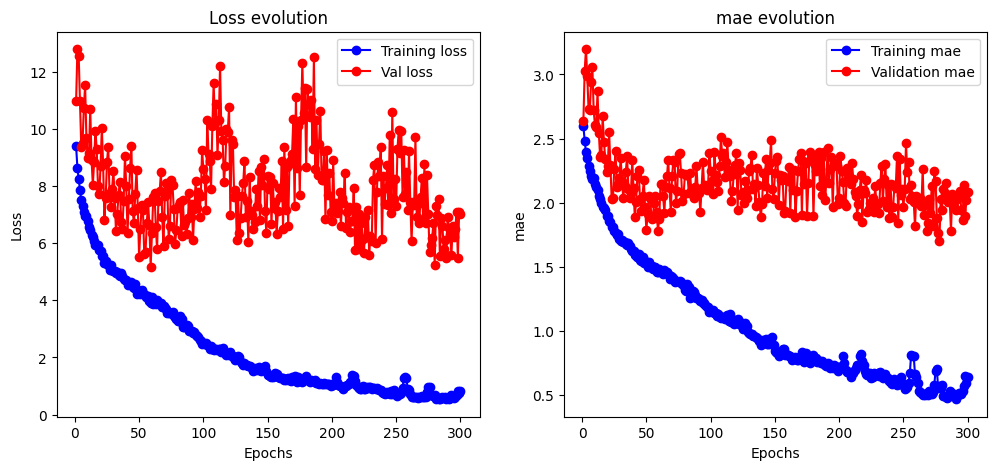

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history.get('mae')
val_mae = history.history.get('val_mae')

epochs = range(1, EPOCHS + 1)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label = "Training loss")
plt.plot(epochs, val_loss, 'ro-', label = "Val loss")

plt.title("Loss evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae, 'bo-', label='Training mae')
plt.plot(epochs, val_mae, 'ro-', label="Validation mae")
plt.title( "mae evolution")
plt.xlabel('Epochs')
plt.ylabel("mae")
plt.legend()
plt.show()

We Should first improve the dataset...


In [ ]:
model.predict(